In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys

sys.path.append('../')

import matplotlib.cm as cm

# Make graphs a bit more beautiful
plt.style.use('Solarize_Light2')
color = cm.viridis_r(np.linspace(.4,.8, 30))


from BumbleTools.processing import feature_importance_splitter,\
                                unique_labels_from_column,\
                                find_tfidf_key_words

from BumbleTools.constants import CATEGORICAL_VAR,\
                                CATEGORICAL_VAR_PROCESSED,\
                                CONTINUOUS_VAR,\
                                ESSAYS 

**Index**

1. EDA:
    - 1.1 Missing values analysis
    - 1.2 Single variable processing and visualization:
        - Target definition
        - Features
    - 1.3 Feature interaction with target
2. Modeling popularity
3. Modeling similarity

## 1. EDA

In [2]:
events = pd.read_csv('../data/events.csv')
user_profiles = pd.read_csv('../data/user_profiles.csv')

In [3]:
user_profiles.head(2)

,age,body_type,drinks,drugs,essay0,essay1,essay2,essay3,essay4,essay5,...,income,job,offspring,orientation,pets,religion,sex,sign,smokes,UID
0,22,a little extra,socially,never,about me:<br />\n<br />\ni would love to think...,currently working as an international agent fo...,making people laugh.<br />\nranting about a go...,"the way i look. i am a six foot half asian, ha...","books:<br />\nabsurdistan, the republic, of mi...",food.<br />\nwater.<br />\ncell phone.<br />\n...,...,-1,transportation,"doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,0
1,35,average,often,sometimes,i am a chef: this is what that means.<br />\n1...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories.<br /...,...,80000,hospitality / travel,"doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,1


In [4]:
events.head(2)

,Active User,Passive User,yes_vote
0,38411,54288,0
1,50211,34398,0


### 1.1 Missing values analysis

In [5]:
user_profiles.isnull().sum()

age                0
body_type       5296
drinks          2985
drugs          14080
essay0          5488
essay1          7572
essay2          9638
essay3         11476
essay4         10537
essay5         10850
essay6         13771
essay7         12451
essay8         19225
essay9         12603
ethnicity       5680
height             3
income             0
job             8198
offspring      35561
orientation        0
pets           19921
religion       20226
sex                0
sign           11056
smokes          5512
UID                0
dtype: int64

There seem to be some null values. It has not been defined to me. But I am going to assume that people that have no information of a given field is because they prefer not to share that information. I will create a feature not provided field to account for this.

On continuous fields we will fill the values with the mean of that feature.

In [6]:
for feature in CATEGORICAL_VAR:
    user_profiles[feature].fillna(feature + '_not_provided', inplace=True)
    

user_profiles['height'].fillna(user_profiles['height'].mean(), inplace=True)
user_profiles['income'].replace(-1, user_profiles['income'].mean(), inplace=True)

In [7]:
user_profiles.isnull().sum()

age                0
body_type          0
drinks             0
drugs              0
essay0          5488
essay1          7572
essay2          9638
essay3         11476
essay4         10537
essay5         10850
essay6         13771
essay7         12451
essay8         19225
essay9         12603
ethnicity          0
height             0
income             0
job                0
offspring          0
orientation        0
pets               0
religion           0
sex                0
sign               0
smokes             0
UID                0
dtype: int64

### 1.2 Single variable processing and visualization:

#### The target

In [8]:
users_popularity = events.groupby('Passive User').agg(
    {"yes_vote": [np.mean, np.size]}
)

users_popularity = users_popularity.reset_index()
users_popularity.columns = users_popularity.columns.droplevel(0)
users_popularity.columns = ['UID', 'yes_vote_ratio', 'times_shown']

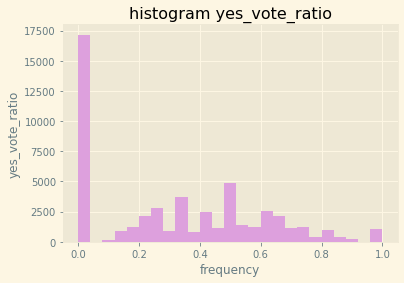

In [9]:
plt.hist(users_popularity['yes_vote_ratio'], bins=25, color='plum')
plt.title('histogram yes_vote_ratio')
plt.ylabel('yes_vote_ratio')
plt.xlabel('frequency');

There seems to be a lot of users having a 0 ratio. We will have to investigate this. It is possible that a lot of this 0s are due to low sample size for some users.

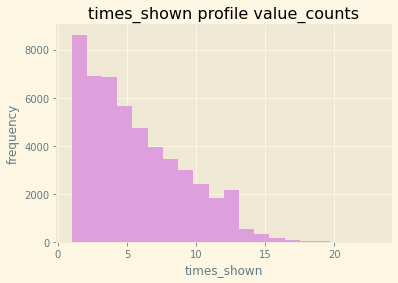

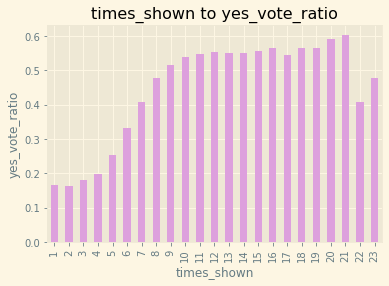

In [10]:
users_popularity.times_shown.hist(bins=20, color='plum')
plt.title('times_shown profile value_counts')
plt.ylabel('frequency')
plt.xlabel('times_shown')
plt.show();

users_popularity.groupby('times_shown').mean()['yes_vote_ratio'].plot.bar(color='plum')
plt.title('times_shown to yes_vote_ratio')
plt.ylabel('yes_vote_ratio')
plt.xlabel('times_shown');

People with a small sample size have a obviously higher chances of having a profile with a binary outcome. This already points that it will probably make sense to change this problem to a classification one.

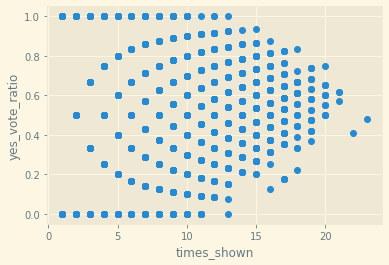

In [63]:
plt.scatter(users_popularity['times_shown'], users_popularity['yes_vote_ratio'])
plt.xlabel('times_shown')
plt.ylabel('yes_vote_ratio')
plt.show();

#### The features

In [12]:
# Process religion and sign to extract the importance
(
    user_profiles['religion'], 
    user_profiles['religion_importance']

) = feature_importance_splitter(user_profiles['religion'])

(
    user_profiles['sign'], 
    user_profiles['sign_importance']

) = feature_importance_splitter(user_profiles['sign'])


user_profiles['height_cm'] = user_profiles['height']*2.54
user_profiles.drop('height', axis=1, inplace=True)
user_profiles.loc[user_profiles['height_cm']<50, 'height_cm'] = user_profiles['height_cm'].mean()

# Deal with age outliars. 110 y.o. guy using bumble? I don't think so 
user_profiles.loc[user_profiles['age']<70, 'age'] = user_profiles['age'].mean()

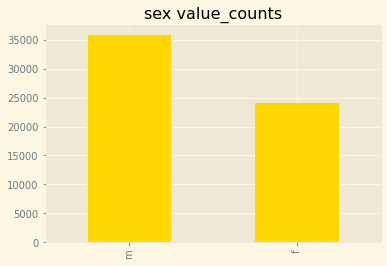

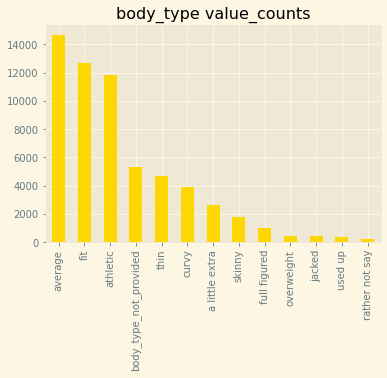

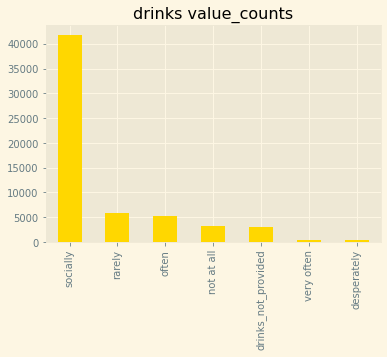

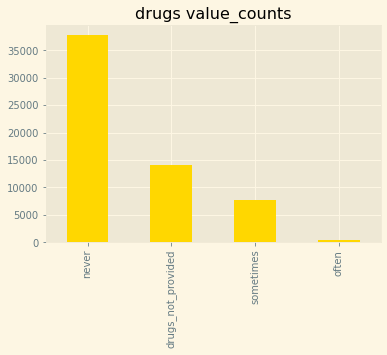

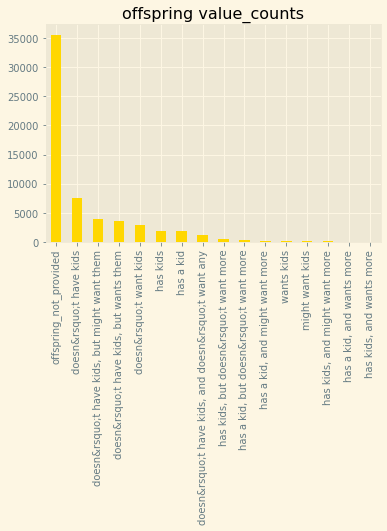

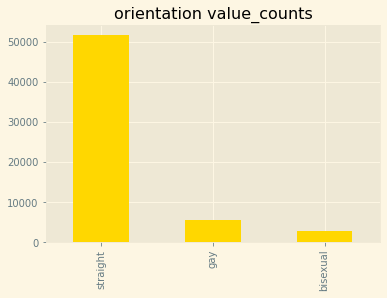

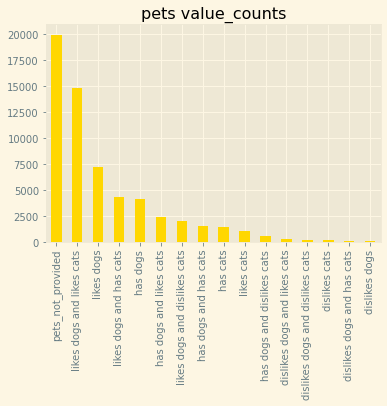

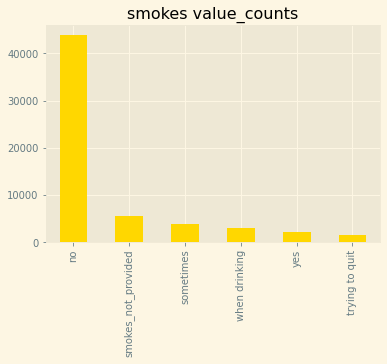

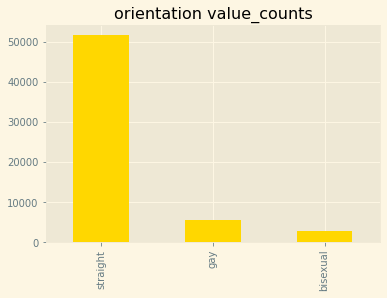

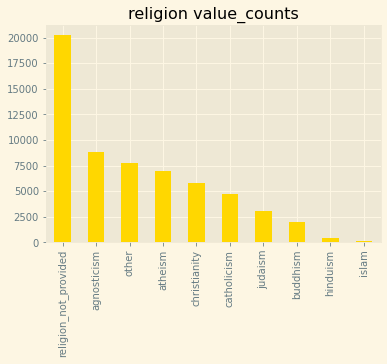

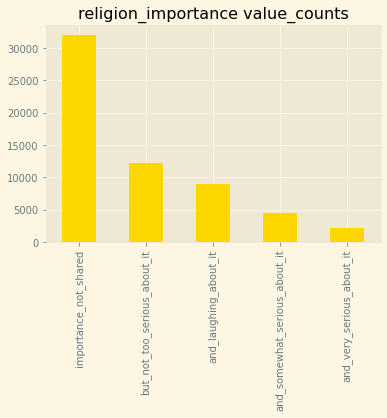

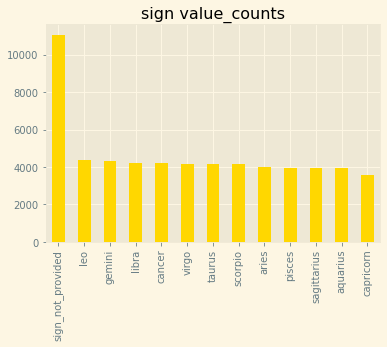

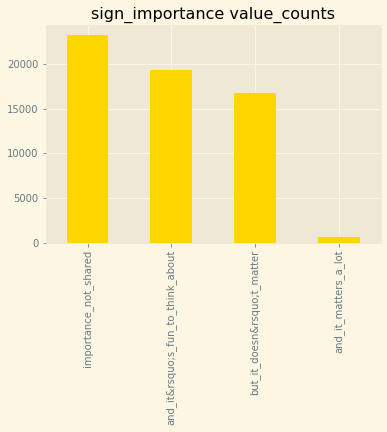

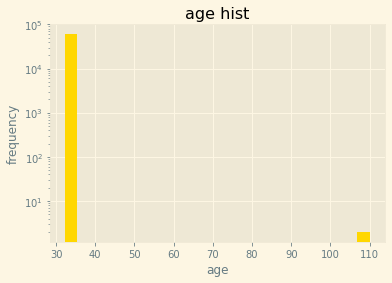

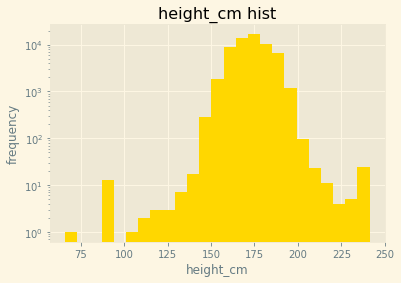

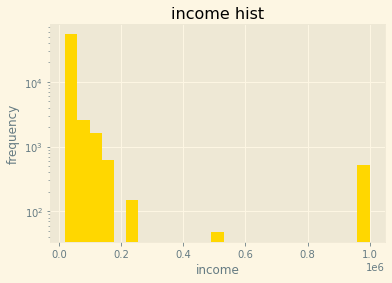

In [13]:
for var in [
    'sex','body_type','drinks','drugs','offspring',
    'orientation','pets','smokes','orientation', 'religion', 
    'religion_importance', 'sign', 'sign_importance'
]:
    user_profiles[var].value_counts().plot.bar(color='gold')
    plt.title('{} value_counts'.format(var))
    plt.show();

for var in CONTINUOUS_VAR:
    plt.hist(user_profiles[var], bins=25, color='gold', log=True);
    plt.title('{} hist'.format(var))
    plt.ylabel('frequency')
    plt.xlabel(var)
    plt.show();

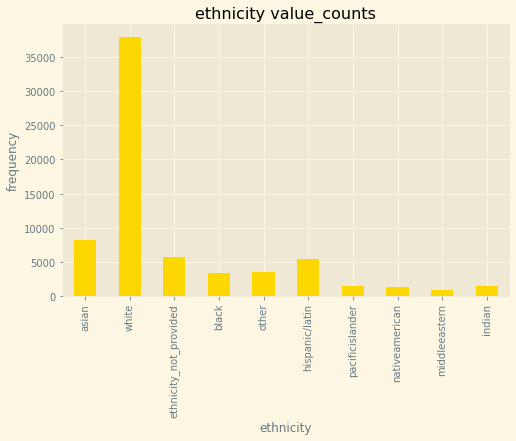

In [14]:
# Find unique ethnicities
unique_ethnicities = unique_labels_from_column(user_profiles['ethnicity'], label_splitter=',')
    
# Create new features for each ethnicity
for ethnicity in unique_ethnicities:
    user_profiles[ethnicity] = user_profiles['ethnicity'].str.replace(' ','').str.contains(ethnicity)
user_profiles.drop('ethnicity', axis=1, inplace=True)

#Plot
plt.figure(figsize=(8,5))
user_profiles[unique_ethnicities].sum().plot.bar(color='gold')
plt.title('ethnicity value_counts')
plt.ylabel('frequency')
plt.xlabel('ethnicity');

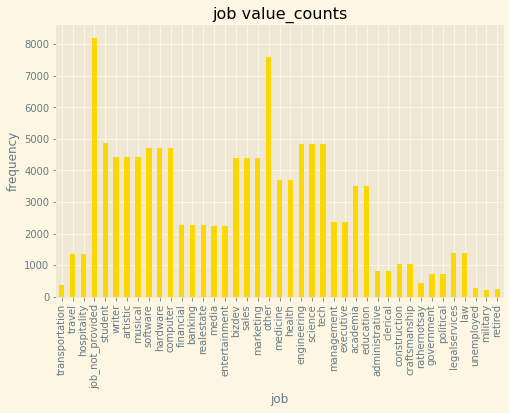

In [15]:
# Find unique jobs
unique_jobs = unique_labels_from_column(user_profiles['job'], label_splitter='/')

# Create new features for each job
for job in unique_jobs:
    user_profiles[job] = user_profiles['job'].str.replace(' ','').str.contains(job)
user_profiles.drop('job', axis=1, inplace=True)

# Plot
plt.figure(figsize=(8,5))
user_profiles[unique_jobs].sum().plot.bar(color='gold')
plt.title('job value_counts')
plt.ylabel('frequency')
plt.xlabel('job');

#### NLP processing of the features

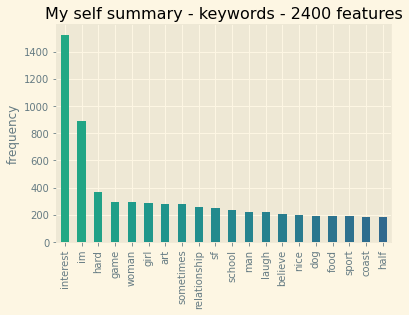

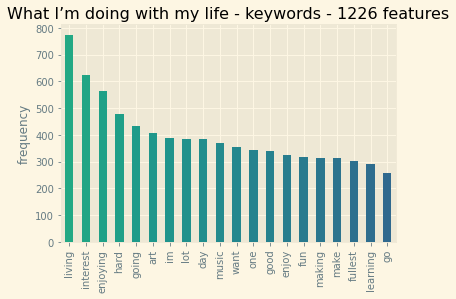

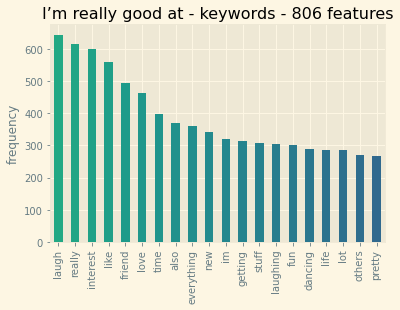

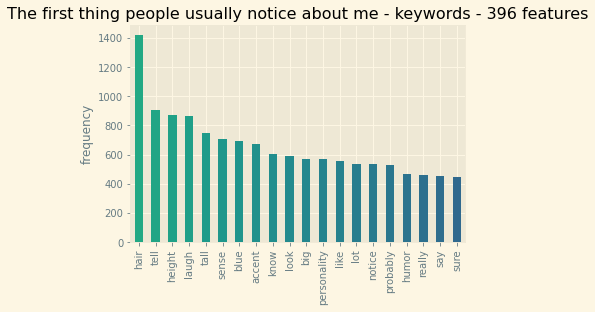

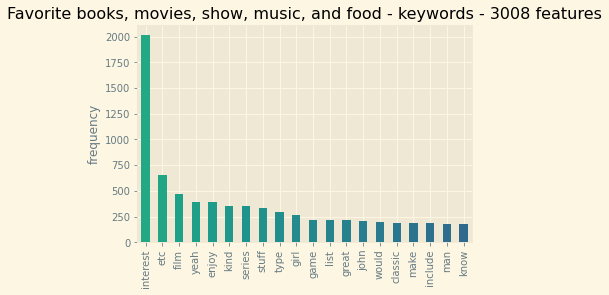

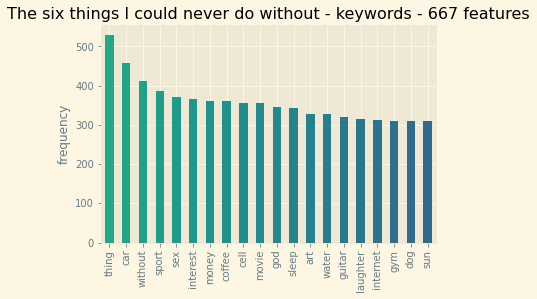

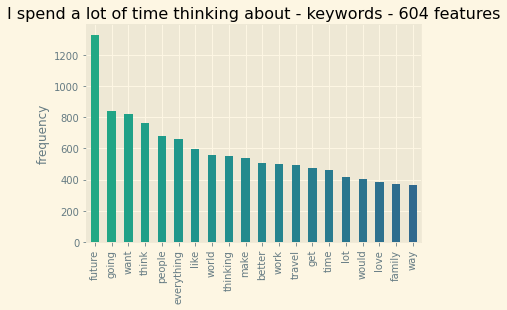

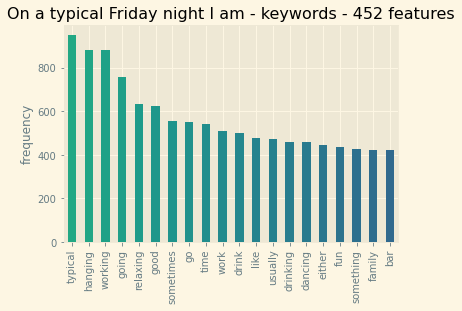

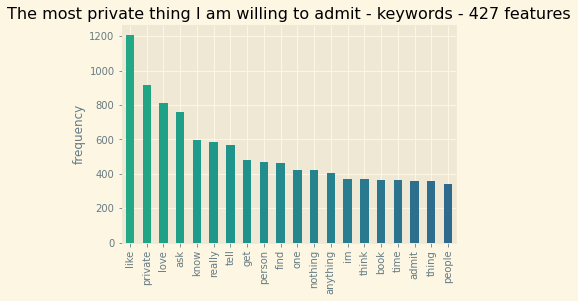

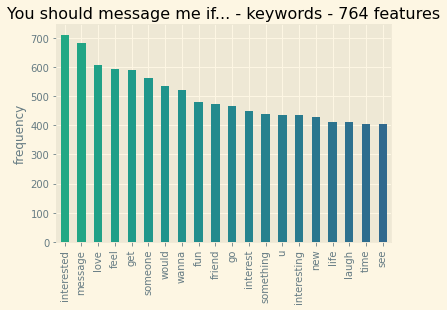

In [16]:
key_word_dic = {}
for essay, description in ESSAYS.items():
    tfidf_key_words = find_tfidf_key_words(user_profiles[essay])
    tfidf_key_words.sum().sort_values(ascending=False).iloc[:20].plot.bar(color=color)
    plt.title('{} - keywords - {} features'.format(description, tfidf_key_words.shape[1]))
    plt.ylabel('frequency')
    plt.show();
    key_word_dic[essay+'_keywords'] = tfidf_key_words  

### 1.3 Feature interaction with target

In [17]:
user_profiles.columns

Index(['age', 'body_type', 'drinks', 'drugs', 'essay0', 'essay1', 'essay2',
       'essay3', 'essay4', 'essay5', 'essay6', 'essay7', 'essay8', 'essay9',
       'income', 'offspring', 'orientation', 'pets', 'religion', 'sex', 'sign',
       'smokes', 'UID', 'religion_importance', 'sign_importance', 'height_cm',
       'asian', 'white', 'ethnicity_not_provided', 'black', 'other',
       'hispanic/latin', 'pacificislander', 'nativeamerican', 'middleeastern',
       'indian', 'transportation', 'travel', 'hospitality', 'job_not_provided',
       'student', 'writer', 'artistic', 'musical', 'software', 'hardware',
       'computer', 'financial', 'banking', 'realestate', 'media',
       'entertainment', 'bizdev', 'sales', 'marketing', 'medicine', 'health',
       'engineering', 'science', 'tech', 'management', 'executive', 'academia',
       'education', 'administrative', 'clerical', 'construction',
       'craftsmanship', 'rathernotsay', 'government', 'political',
       'legalservices', 'law

In [18]:
# Merge target and features
user_profiles = user_profiles.merge(users_popularity, on='UID', how='left')
user_profiles[user_profiles['yes_vote_ratio'].isnull()]['orientation'].value_counts()

gay         5573
bisexual    2767
straight     817
Name: orientation, dtype: int64

The data I have seems to have no information on the voting of gay and bisexual people. I will therefore drop this column for the dataset.

In [19]:
user_profiles.drop(['orientation'], axis=1, inplace=True)

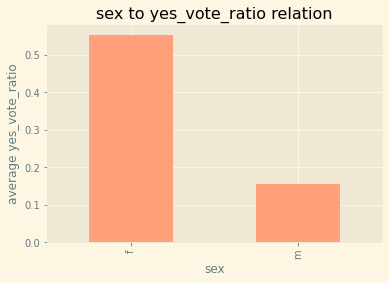

In [20]:
user_profiles.groupby('sex')['yes_vote_ratio'].mean().plot.bar(color='lightsalmon')
plt.title('sex to yes_vote_ratio relation')
plt.ylabel('average yes_vote_ratio')
plt.show()

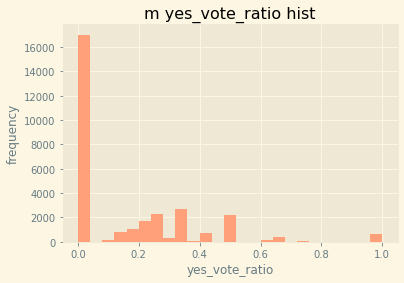

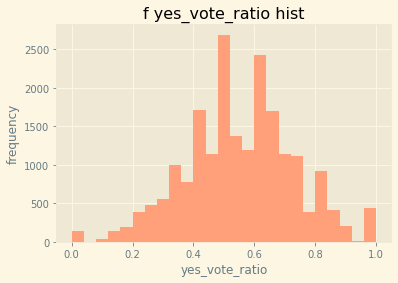

In [21]:
for sex in ['m', 'f']:
    user_profiles.loc[user_profiles['sex']==sex, 'yes_vote_ratio'].hist(bins=25, color='lightsalmon')
    plt.title('{} yes_vote_ratio hist'.format(sex))
    plt.xlabel('yes_vote_ratio')
    plt.ylabel('frequency')
    plt.show()

It doesn't make any sense to do an analysis of popularity for male and female together because the sex has a confounding effect. If we keep them together we will see differences on the yes vote ration that are due to sex influencing the other variable.

In [22]:
user_profiles_male = user_profiles[user_profiles['sex']=='m']
user_profiles_female = user_profiles[user_profiles['sex']=='f']

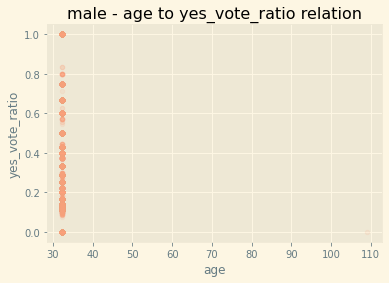

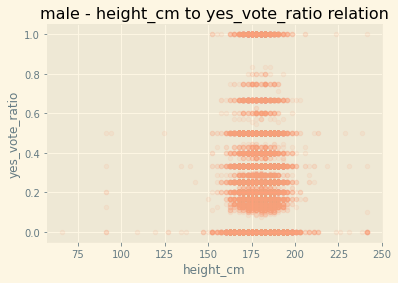

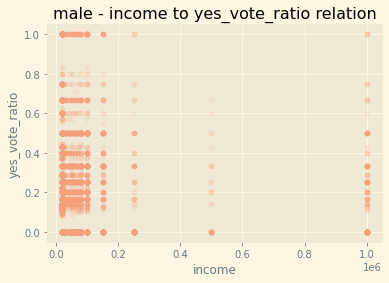

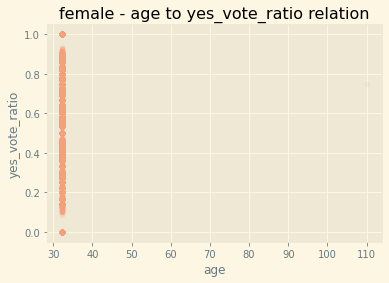

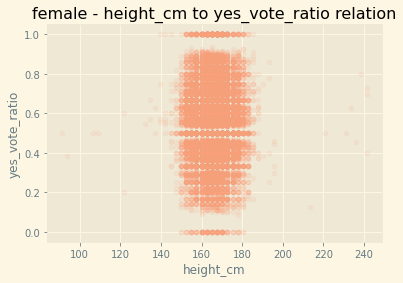

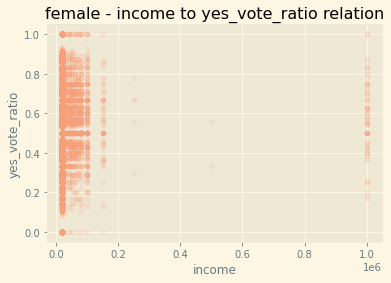

In [23]:
for feat in CONTINUOUS_VAR:
    user_profiles_male.plot.scatter(feat, 'yes_vote_ratio', alpha=0.1, color='lightsalmon')
    plt.title('male - {} to yes_vote_ratio relation'.format(feat))
    plt.show()
    
for feat in CONTINUOUS_VAR:
    user_profiles_female.plot.scatter(feat, 'yes_vote_ratio', alpha=0.1, color='lightsalmon')
    plt.title('female - {} to yes_vote_ratio relation'.format(feat))
    plt.show();

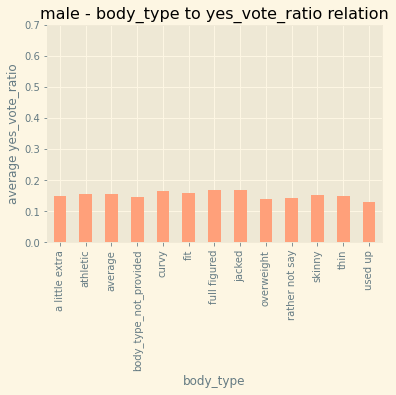

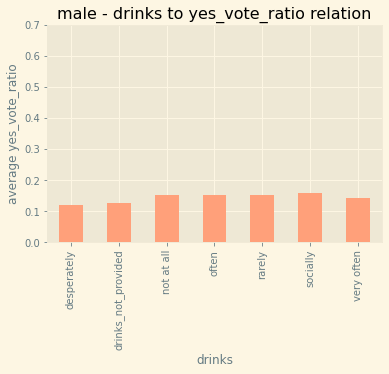

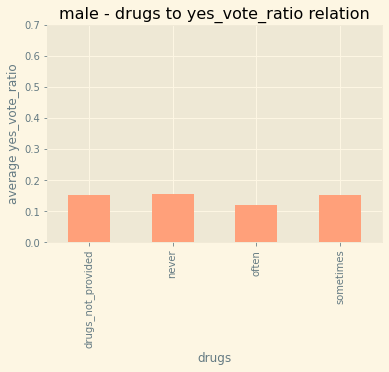

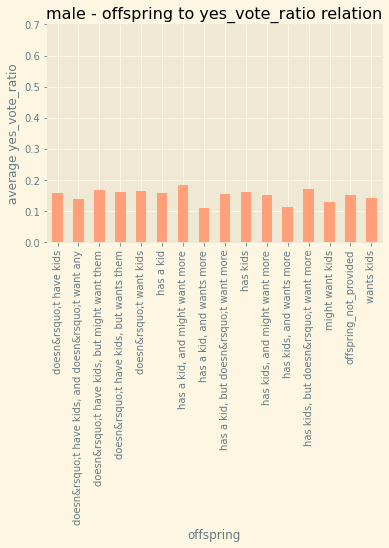

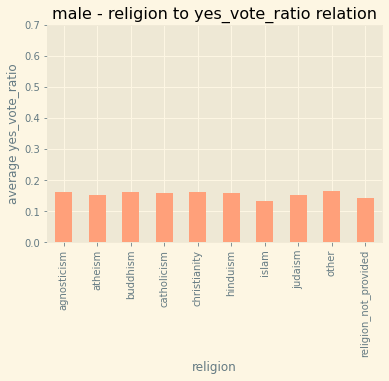

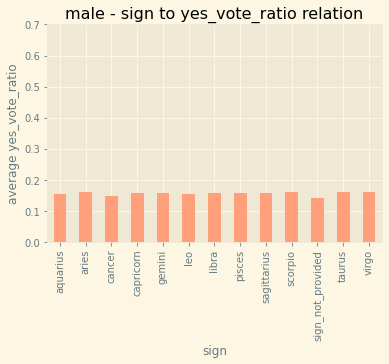

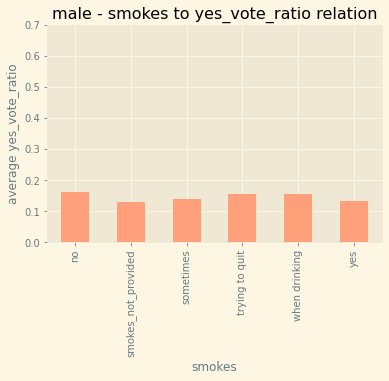

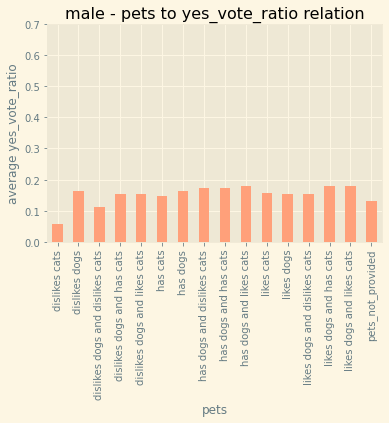

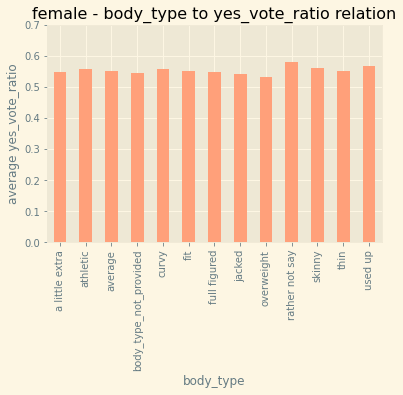

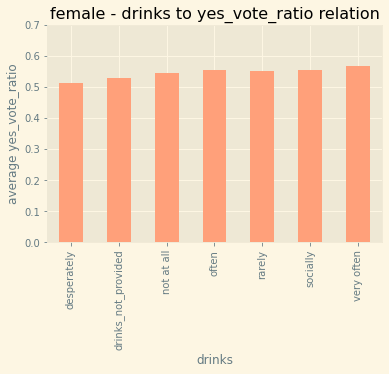

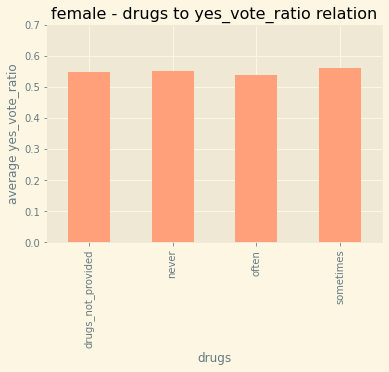

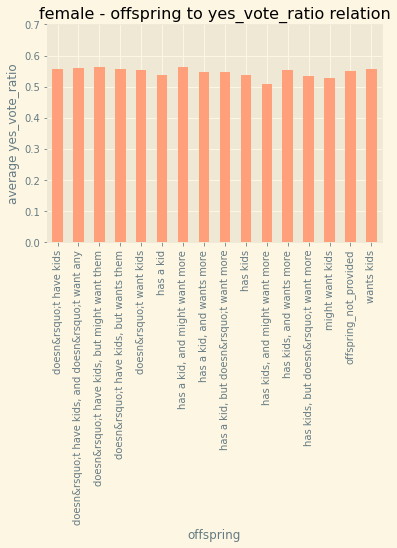

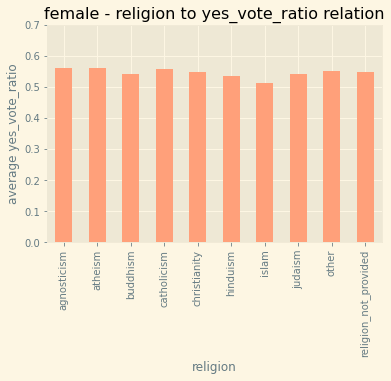

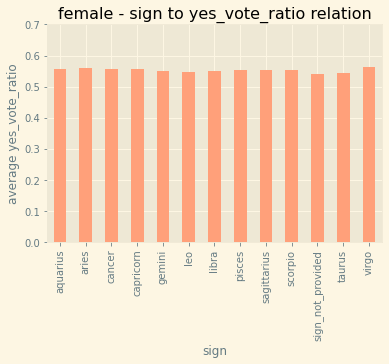

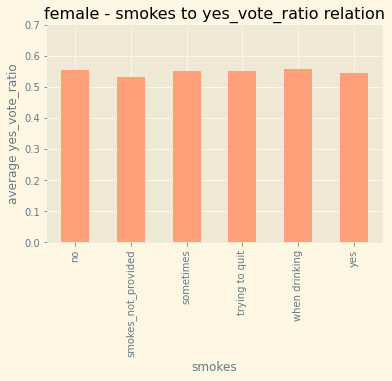

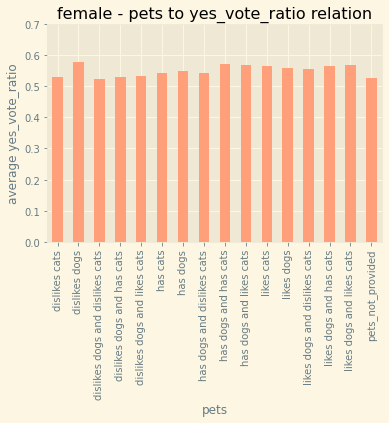

In [24]:
for feature in CATEGORICAL_VAR:
    if feature not in ('ethnicity', 'job'):
        user_profiles_male.groupby(feature)['yes_vote_ratio'].mean().plot.bar(color='lightsalmon')
        plt.title('male - {} to yes_vote_ratio relation'.format(feature))
        plt.ylabel('average yes_vote_ratio')
        plt.ylim(0, 0.7)
        plt.show()
    
for feature in CATEGORICAL_VAR:
    if feature not in ('ethnicity', 'job'):
        user_profiles_female.groupby(feature)['yes_vote_ratio'].mean().plot.bar(color='lightsalmon')
        plt.title('female - {} to yes_vote_ratio relation'.format(feature))
        plt.ylabel('average yes_vote_ratio')
        plt.ylim(0, 0.7)
        plt.show();

In [25]:
for job in unique_jobs:
    print(job, user_profiles_female.groupby(job)['yes_vote_ratio'].mean())

transportation transportation
False    0.551777
True     0.588400
Name: yes_vote_ratio, dtype: float64
travel travel
False    0.551274
True     0.576811
Name: yes_vote_ratio, dtype: float64
hospitality hospitality
False    0.551274
True     0.576811
Name: yes_vote_ratio, dtype: float64
job_not_provided job_not_provided
False    0.553811
True     0.540684
Name: yes_vote_ratio, dtype: float64
student student
False    0.550822
True     0.563338
Name: yes_vote_ratio, dtype: float64
writer writer
False    0.551484
True     0.556748
Name: yes_vote_ratio, dtype: float64
artistic artistic
False    0.551484
True     0.556748
Name: yes_vote_ratio, dtype: float64
musical musical
False    0.551484
True     0.556748
Name: yes_vote_ratio, dtype: float64
software software
False    0.551989
True     0.547213
Name: yes_vote_ratio, dtype: float64
hardware hardware
False    0.551989
True     0.547213
Name: yes_vote_ratio, dtype: float64
computer computer
False    0.551989
True     0.547213
Name: yes_vote

In [26]:
for eth in unique_ethnicities:
    print(eth, user_profiles_female.groupby(eth)['yes_vote_ratio'].mean())

asian asian
False    0.552449
True     0.548277
Name: yes_vote_ratio, dtype: float64
white white
False    0.547923
True     0.554108
Name: yes_vote_ratio, dtype: float64
ethnicity_not_provided ethnicity_not_provided
False    0.552389
True     0.546919
Name: yes_vote_ratio, dtype: float64
black black
False    0.551594
True     0.556301
Name: yes_vote_ratio, dtype: float64
other other
False    0.551683
True     0.552926
Name: yes_vote_ratio, dtype: float64
hispanic/latin hispanic/latin
False    0.551504
True     0.556143
Name: yes_vote_ratio, dtype: float64
pacificislander pacificislander
False    0.551672
True     0.561896
Name: yes_vote_ratio, dtype: float64
nativeamerican nativeamerican
False    0.551497
True     0.572328
Name: yes_vote_ratio, dtype: float64
middleeastern middleeastern
False    0.551908
True     0.548541
Name: yes_vote_ratio, dtype: float64
indian indian
False    0.551837
True     0.553481
Name: yes_vote_ratio, dtype: float64


In [27]:
for job in unique_jobs:
    print(job, user_profiles_male.groupby(job)['yes_vote_ratio'].mean())

transportation transportation
False    0.154255
True     0.153233
Name: yes_vote_ratio, dtype: float64
travel travel
False    0.154359
True     0.149046
Name: yes_vote_ratio, dtype: float64
hospitality hospitality
False    0.154359
True     0.149046
Name: yes_vote_ratio, dtype: float64
job_not_provided job_not_provided
False    0.156470
True     0.138742
Name: yes_vote_ratio, dtype: float64
student student
False    0.154753
True     0.147502
Name: yes_vote_ratio, dtype: float64
writer writer
False    0.154359
True     0.152688
Name: yes_vote_ratio, dtype: float64
artistic artistic
False    0.154359
True     0.152688
Name: yes_vote_ratio, dtype: float64
musical musical
False    0.154359
True     0.152688
Name: yes_vote_ratio, dtype: float64
software software
False    0.152533
True     0.166949
Name: yes_vote_ratio, dtype: float64
hardware hardware
False    0.152533
True     0.166949
Name: yes_vote_ratio, dtype: float64
computer computer
False    0.152533
True     0.166949
Name: yes_vote

In [28]:
for eth in unique_ethnicities:
    print(eth, user_profiles_male.groupby(eth)['yes_vote_ratio'].mean())

asian asian
False    0.153836
True     0.156815
Name: yes_vote_ratio, dtype: float64
white white
False    0.148892
True     0.157400
Name: yes_vote_ratio, dtype: float64
ethnicity_not_provided ethnicity_not_provided
False    0.155215
True     0.144767
Name: yes_vote_ratio, dtype: float64
black black
False    0.154691
True     0.146199
Name: yes_vote_ratio, dtype: float64
other other
False    0.153905
True     0.157039
Name: yes_vote_ratio, dtype: float64
hispanic/latin hispanic/latin
False    0.154682
True     0.149776
Name: yes_vote_ratio, dtype: float64
pacificislander pacificislander
False    0.154341
True     0.150695
Name: yes_vote_ratio, dtype: float64
nativeamerican nativeamerican
False    0.154348
True     0.149323
Name: yes_vote_ratio, dtype: float64
middleeastern middleeastern
False    0.154624
True     0.132441
Name: yes_vote_ratio, dtype: float64
indian indian
False    0.154347
True     0.151157
Name: yes_vote_ratio, dtype: float64


Males seem to show more variability on the yes_vote_ratio than females. 

- Males vote yes to most females without looking at their characteristics. Maybe they care more about the picture?
- Woman seem to have more preference for some features than others.

## 2. Modeling popularity

In [29]:
from sklearn.model_selection import cross_val_score 
from sklearn import linear_model 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

In [30]:
userprof_drop_na = user_profiles.dropna(subset=['yes_vote_ratio'])

In [31]:
## Remove outliers from income
# mean_income = userprof_drop_na.loc[userprof_drop_na['income']<=400000, 'income'].mean()
# userprof_drop_na.loc[userprof_drop_na['income']>400000, 'income'] = mean_income

In [32]:
# # Keep only users that were shown 3 or more times
# # Is this a good idea?
# userprof_drop_na = userprof_drop_na[userprof_drop_na['times_shown']>=3]

In [33]:
# Model Class
class popularity_model:
    def __init__(self, user_data, model, sex=None, classification=False):
        self.user_data = user_data
        self.model = model
        self.sex = sex
        self.classification = classification
        
    def dummify_variables(self, df, categorical_var):
        for col in categorical_var:
            dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
            df = pd.concat([df, dummies], axis=1)
            df.drop([col], axis=1, inplace=True)
        return df
        
    def fit(self):
        user_data_X = self.user_data.drop(list(ESSAYS.keys()), axis=1)
        # Dummify variables
        X = self.dummify_variables(user_data_X, CATEGORICAL_VAR_PROCESSED)
        Y = X['yes_vote_ratio']
        X = X.astype('float')
        
        
        if self.sex in (0,1):
            # Filter sex
            mask = X['sex_m']==self.sex
            X = X.loc[mask].copy()
            Y = Y.loc[mask]
            X.drop(['UID', 'yes_vote_ratio', 'times_shown', 'sex_m'], axis=1, inplace=True)
        else:
            X.drop(['UID', 'yes_vote_ratio', 'times_shown'], axis=1, inplace=True)
        
        
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, 
            Y, 
            test_size=0.2, 
            random_state=42
        )

        # Fit model
        model_fit = self.model.fit(X_train, y_train) 

        print(
            'test_score: {}\n'.format(model_fit.score(X_test, y_test)), 
            'train_score: {}'.format(model_fit.score(X_train, y_train)))
        if self.classification:
            print('baseline: ', max(Y.mean(), 1-Y.mean()))
            
        self.y_test = y_test
        self.prediction = model_fit.predict(X_test)
        self.model_fit = model_fit
        self.features = X.columns
    
    def analyze_linear_coefficients(self):
        if self.classification:
            coef = self.model.coef_[0]
        else:
            coef = self.model.coef_
        
        feature_coeficients = pd.DataFrame(
            zip(self.features, coef), 
            columns=['features', 'coefs']
        )
        
        feature_coeficients = feature_coeficients.sort_values('coefs', ascending=False)

        plt.bar(feature_coeficients.head(20)['features'], feature_coeficients.head(20)['coefs'])
        plt.xticks(rotation=90)
        plt.show();

        plt.bar(feature_coeficients.tail(20)['features'], feature_coeficients.tail(20)['coefs'])
        plt.xticks(rotation=90)
        plt.show();
        

### 2.1 Fit a regression

In [34]:
2.2678428995392963e-05 *100

0.0022678428995392963

0
test_score: 2.2678428995392963e-05
 train_score: 0.018793214210534148


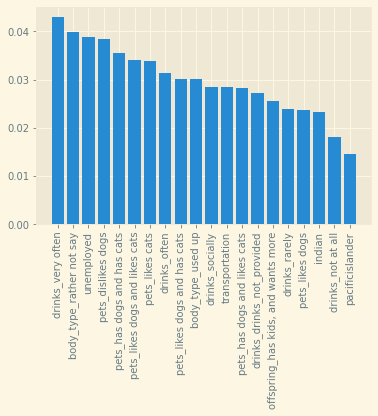

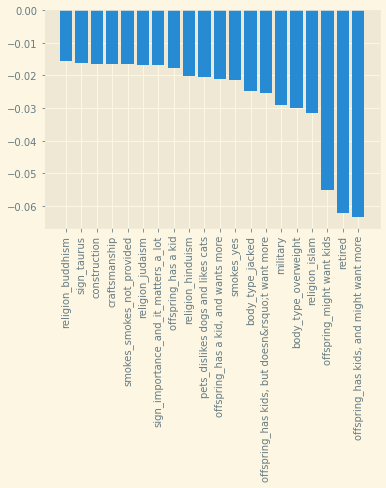

1
test_score: 0.011843164829406172
 train_score: 0.01520821294550545


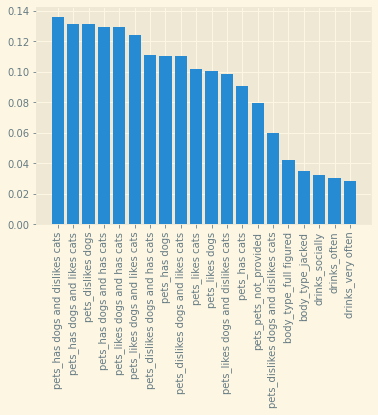

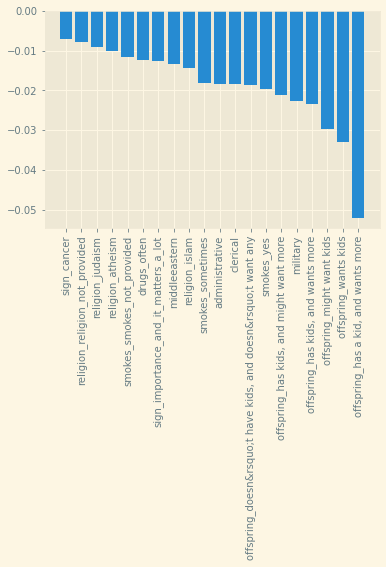

In [35]:
for sex in [0,1]:
    print (sex)
    linear_regression = popularity_model(
        userprof_drop_na,
        linear_model.LinearRegression(),
        sex
    )

    linear_regression.fit()
    linear_regression.analyze_linear_coefficients()

In [36]:
rf = RandomForestRegressor( 
    200,
    max_features=0.3,
    max_depth=5
)
    
for sex in [None, 0, 1]:
    print (sex)
    linear_regression = popularity_model(
        userprof_drop_na,
        rf,
        sex
    )

    linear_regression.fit()

None
test_score: 0.47166917220036186
 train_score: 0.47698133959128985
0
test_score: 0.007772305994986128
 train_score: 0.022551561763347494
1
test_score: 0.01019746857093018
 train_score: 0.020900393612280244


None
test_score: 0.32752936585916437
 train_score: 0.33479026774623943


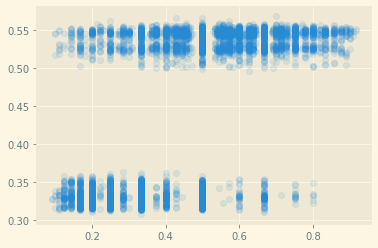

0.025097107933886656
0
test_score: 0.004360438180395332
 train_score: 0.023047145665321622


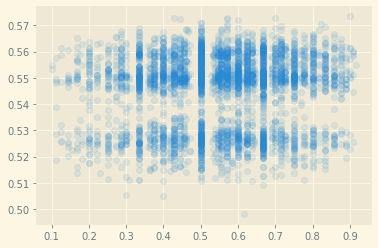

0.027700677834204393
1
test_score: 0.005102224507549935
 train_score: 0.026944258877404703


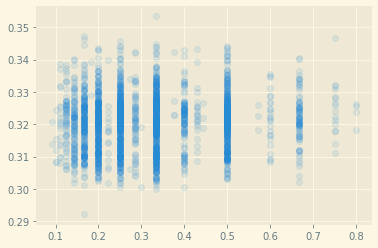

0.02010939714618224


In [37]:
# Fit a regression only to the continuous target
userprof_drop_na_cont = userprof_drop_na[~userprof_drop_na['yes_vote_ratio'].isin([0,1])]

for sex in [None, 0, 1]:
    print (sex)
    model = popularity_model(
        userprof_drop_na_cont, 
        rf, 
        sex
    )
    
    model.fit()

    y =  model.y_test
    prediction = model.prediction

    plt.scatter(y, prediction, alpha=0.1)
    plt.show()

    print(mean_squared_error(y, prediction))

In [38]:
## Fit regressions using essay data. VERY SLOW and low performace.
# userprof_drop_na_essay = userprof_drop_na
# for essay in list(ESSAYS.keys()):
#     print(essay)
#     tfidf_key_words = find_tfidf_key_words(userprof_drop_na[essay], min_word_freq=200).add_prefix(essay+'_')
#     tfidf_key_words.index = userprof_drop_na.index
#     userprof_drop_na_essay = pd.concat([userprof_drop_na_essay, tfidf_key_words], axis=1)

#     rf = RandomForestRegressor( 
#         100,
#         max_features=0.3,
#         max_depth=5
#     )
#     for sex in [0,1]:
#         print (sex)
#         fit_model_popularity(userprof_drop_na_essay, rf, sex)

### 2.1 Fit a classification problem

0
test_score: 0.8602045786653677
 train_score: 0.8602654651729177
baseline:  0.8602532878714076


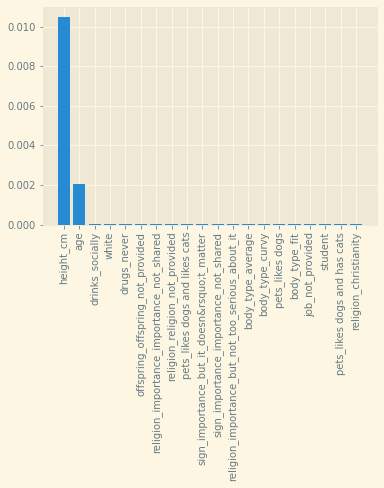

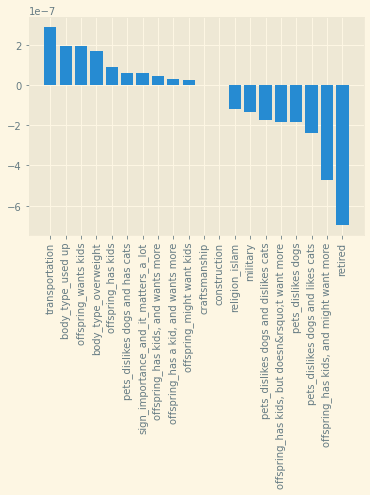

1
test_score: 0.8592200925313945
 train_score: 0.860908001817656
baseline:  0.8605704088039922


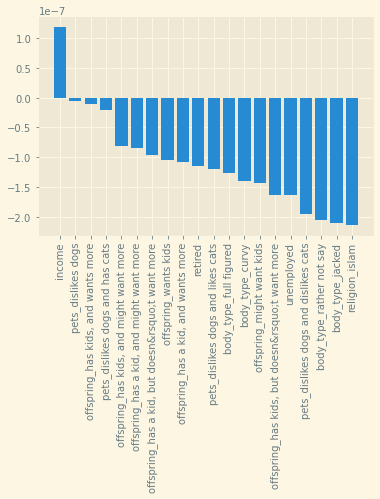

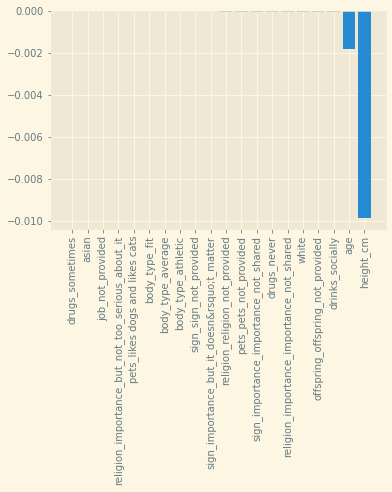

In [39]:
userprof_drop_na_binary = userprof_drop_na.copy()
threshold_binary = 0.35
userprof_drop_na_binary.loc[userprof_drop_na['yes_vote_ratio']>threshold_binary, 'yes_vote_ratio']=1
userprof_drop_na_binary.loc[userprof_drop_na['yes_vote_ratio']<=threshold_binary, 'yes_vote_ratio']=0
    
for sex in [0,1]:
    print (sex)
    linear_regression = popularity_model(
        userprof_drop_na_binary,
        linear_model.LogisticRegression(),
        sex,
        classification=True
    )

    linear_regression.fit()
    linear_regression.analyze_linear_coefficients()

In [40]:
rfc = RandomForestClassifier( 
    200,
    max_features=0.3,
    max_depth=5
)
    
for sex in [0,1]:
    print (sex)
    model = popularity_model(
        userprof_drop_na_binary,
        rfc,
        sex,
        classification=True
    )

    model.fit()

0
test_score: 0.8602045786653677
 train_score: 0.8602654651729177
baseline:  0.8602532878714076
1
test_score: 0.8592200925313945
 train_score: 0.860908001817656
baseline:  0.8605704088039922


## 3. Modeling similarity

In [41]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine

In [44]:
def dummify_variables(df, categorical_var):
    for col in categorical_var:
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
        df = pd.concat([df, dummies], axis=1)
        df.drop([col], axis=1, inplace=True)
    return df

In [ ]:
def analyze_linear_coefficients(coef, features):
        
        feature_coeficients = pd.DataFrame(
            zip(features, coef), 
            columns=['features', 'coefs']
        )
        
        feature_coeficients = feature_coeficients.sort_values('coefs', ascending=False)

        plt.bar(feature_coeficients.head(20)['features'], feature_coeficients.head(20)['coefs'])
        plt.xticks(rotation=90)
        plt.show();
        
        plt.bar(feature_coeficients.tail(20)['features'], feature_coeficients.tail(20)['coefs'])
        plt.xticks(rotation=90)
        plt.show();

In [45]:
# user_profiles['yes_vote_ratio'].fillna(0, inplace=True)

In [46]:
user_profiles_X = user_profiles.drop(list(ESSAYS.keys()), axis=1)
# Dummify variables
X = dummify_variables(user_profiles_X, CATEGORICAL_VAR_PROCESSED)

X.drop(['UID', 'yes_vote_ratio', 'times_shown', 'sex_m'], axis=1, inplace=True)
X = X.astype('float')

In [47]:
## This method blows up when dataframe gets bigger
# cosine_similarity_matrix = pd.DataFrame(cosine_similarity_matrix, index=X.index, columns=X.index)
# events.apply(lambda x: cosine_similarity_matrix.loc[x['Active User'],x['Passive User']] , axis=1)

In [48]:
print('Baseline:')
print(1-events['yes_vote'].mean())

Baseline:
0.6027803585561405


In [49]:
# Initial method to calculate similarity based on cosine difference

events['cosine_similarity'] = events.apply(
    lambda x: (1.0-cosine(X.loc[x['Active User']], X.loc[x['Passive User']])),
    axis=1
)

X_train, X_test, y_train, y_test = train_test_split(
    events['cosine_similarity'], 
    events['yes_vote'], 
    test_size=0.2, 
    random_state=42
) 

lm = linear_model.LogisticRegression()
model = lm.fit(np.array(X_train).reshape(-1, 1), y_train) 

print (
    model.score(np.array(X_test).reshape(-1, 1), y_test), 
    model.score(np.array(X_train).reshape(-1, 1), y_train)
)

0.6021816179759816 0.6029300437011803


In [57]:
# Second method Calculate a vector of the differences between active and passive users 
# and fit a model to the vector to try to predict yes votes
events_diff = events.apply(
    lambda x: X.loc[x['Active User']]- X.loc[x['Passive User']],
    axis=1
)

# # Normalize diffs
# from sklearn import preprocessing

# x = events_diff.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# events_diff = pd.DataFrame(x_scaled)

events_X = pd.concat([events, events_diff], axis=1)

Y = events['yes_vote']
events_X.drop(['yes_vote', 'Active User', 'Passive User', 'cosine_similarity'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(
    events_X, 
    Y, 
    test_size=0.2, 
    random_state=42
) 

In [58]:
lm = linear_model.LogisticRegression()
model = lm.fit(X_train, y_train) 

print (model.score(X_test, y_test), model.score(X_train, y_train))

0.6420460410859915 0.6406954337428168


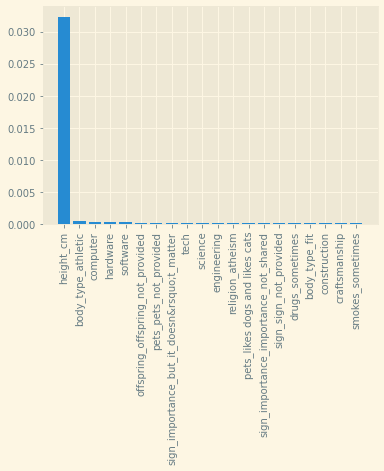

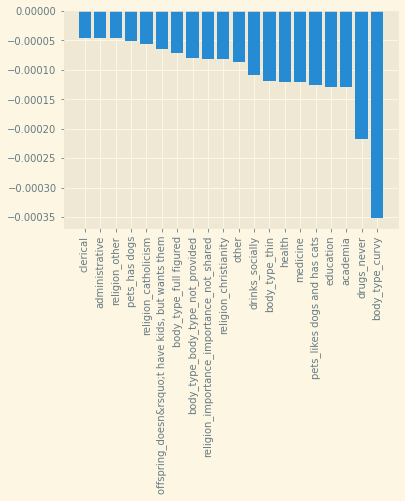

In [60]:
analyze_linear_coefficients(model.coef_[0], X_train.columns)

In [61]:
lm = RandomForestClassifier(
        100,
        max_features=0.3,
        max_depth=5
    )
model = lm.fit(X_train, y_train) 

print (model.score(X_test, y_test), model.score(X_train, y_train))

0.6494442723925536 0.6495604074188776
